# Z-scoring WPM and Accuracy by trial-type


## Set up


In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import matplotlib.pyplot as plt

from src import process
from src import plot

# Load the CSV file results.csv into a dataframe and add some processed columns
df = process.load_processed_results()

display(df.tail())

,id,is_pb,wpm,acc,raw_wpm,consistency,char_stats,mode,mode2,quote_length,...,iti_all,iti_session,time_since_last_new_sesh,combined_id,trial_type_id,z_wpm,z_acc,trial_num,trial_type_num,log_norm_wpm
1823,65940c8ea65b7d25a1993863,0,33.2,96.80,33.2,60.01,"332,0,0,0",time,120,-1,...,18.0,18.0,138000,29,2,1.445331,1.029419,1824,358,7.839566
1824,65940d16a65b7d25a1993e31,0,31.0,91.20,31.0,61.47,"310,0,0,0",time,120,-1,...,16.0,16.0,274000,29,2,0.914677,-0.514066,1825,359,6.796597
1825,65955ea2a65b7d25a1a4b674,0,33.5,95.99,33.5,63.41,"335,0,0,0",time,120,-1,...,86292.0,NaN,0,29,2,1.517693,0.806165,1826,360,7.981789
1826,65955f2ea65b7d25a1a4bc77,0,33.4,95.20,33.4,62.92,"334,0,0,0",time,120,-1,...,20.0,20.0,140000,29,2,1.493572,0.588423,1827,361,7.934381
1827,65955faba65b7d25a1a4c20f,0,29.7,90.91,29.7,58.77,"297,0,0,0",time,120,-1,...,5.0,5.0,0,29,2,0.601110,-0.593997,1828,362,6.180298


## Trial-type definitions

How should we define the way we group trials?

Each trial is defined by the features in df.columns. Some example features and their values are:

- mode: 'time', 'custom', 'words', 'quote'
- mode2: '30', '60', 'custom', '15', '120', '10', '25', '50', '100', '1899', '6292'
- punctuation: False, True
- numbers: False, True
- language: 'english', 'english_1k', 'english_25k', 'english_10k', 'code_python_5k',
  'code_python_1k', 'thai', 'english_5k'
- funbox: 'none', 'ascii', 'weakspot'
- difficulty: 'normal'
- lazyMode: False
- blindMode: False

Any unique combination of these features is a trial-type.
`df['combined_id']` is a trial-type id that is unique to each combination of these features.
`df["trial_type_id"]` is the same as `df["combined_id"]` but the labels are re-ordered by group size.


In [3]:
# List the column names
print(f"All columns: {df.columns}")
print(f"Unique values for 'language': {df['language'].unique()}")

All columns: Index(['id', 'is_pb', 'wpm', 'acc', 'raw_wpm', 'consistency', 'char_stats',
       'mode', 'mode2', 'quote_length', 'restart_count', 'test_duration',
       'afk_duration', 'incomplete_test_seconds', 'punctuation', 'numbers',
       'language', 'funbox', 'difficulty', 'lazy_mode', 'blind_mode',
       'bailed_out', 'tags', 'timestamp', 'datetime', 'day_of_week',
       'time_of_day_sec', 'time_diff_sec', 'new_sesh_ind', 'iti_all',
       'iti_session', 'time_since_last_new_sesh', 'combined_id',
       'trial_type_id', 'z_wpm', 'z_acc', 'trial_num', 'trial_type_num',
       'log_norm_wpm'],
      dtype='object')
Unique values for 'language': ['english' 'english_1k' 'english_25k' 'english_10k' 'code_python_5k'
 'code_python_1k' 'thai' 'english_5k']


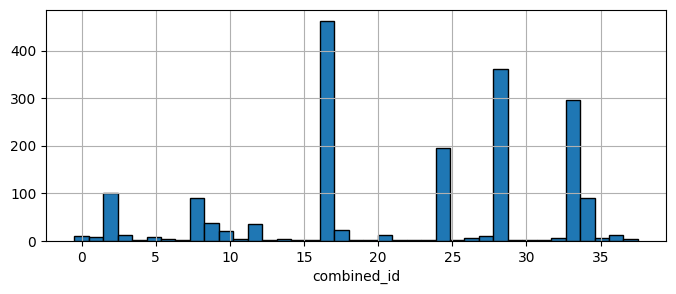

In [4]:
# Histogram of combined_id
fig = plt.figure(figsize=(8, 3))
ax = df["combined_id"].hist(
    bins=df["combined_id"].nunique(),
    edgecolor="black",
    align="left",
)
ax.set_xlabel("combined_id")
plt.show()

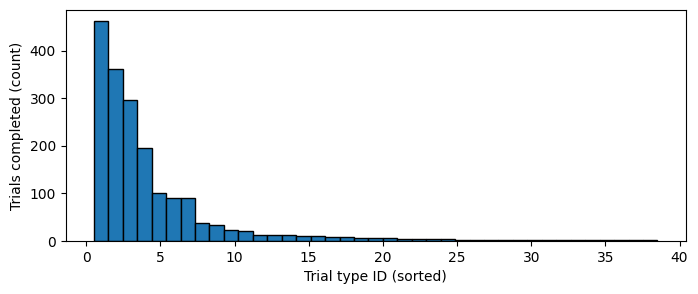

In [5]:
# Histogram of trial_type_id
fig = plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.hist(
    df["trial_type_id"],
    bins=df["trial_type_id"].nunique(),
    edgecolor="black",
    align="left",
)
ax.set_xlabel("Trial type ID (sorted)")
ax.set_ylabel("Trials completed (count)")
plt.show()

## Coeffficient of variation by trial-type

Coefficient of variation is the standard deviation divided by the mean.


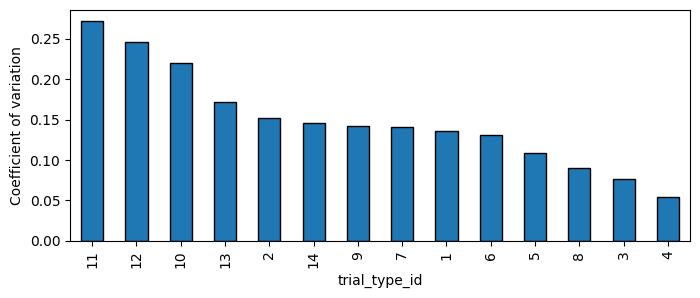

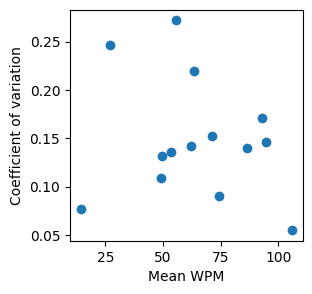

In [6]:
# Select only the trial_type_id with a minimum number of trials
min_trials = 10
trial_type_counts = df["trial_type_id"].value_counts()
trial_type_counts = trial_type_counts[trial_type_counts > min_trials]
df_filtered = df[df["trial_type_id"].isin(trial_type_counts.index)]

# Calculate the coefficient of variation for each trial_type_id
wpm_std = df_filtered.groupby("trial_type_id")["wpm"].std()
wpm_mean = df_filtered.groupby("trial_type_id")["wpm"].mean()
cv = wpm_std / wpm_mean
cv = cv.sort_values(ascending=False)

# Plot the coefficient of variation
fig = plt.figure(figsize=(8, 3))
ax = cv.plot(kind="bar", edgecolor="black")
ax.set_xlabel("trial_type_id")
ax.set_ylabel("Coefficient of variation")
plt.show()

# Scatter of cv as a function of mean
fig = plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.scatter(wpm_mean, cv)
ax.set_xlabel("Mean WPM")
ax.set_ylabel("Coefficient of variation")
plt.show()

## All trial correlation betwen WPM and Accuracy


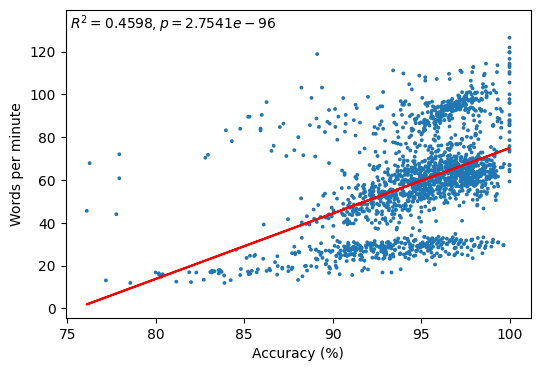

In [7]:
# Correlation between wpm and acc
fig = plt.figure(figsize=(6, 4))
ax = plot.df_scatter(df, "acc", "wpm", plot_regression=True, s=3)
plt.show()

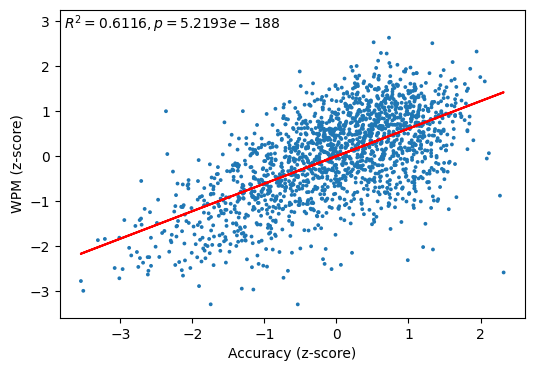

In [8]:
# Correlation between z-scored wpm and acc
fig = plt.figure(figsize=(6, 4))
ax = plot.df_scatter(df, "z_acc", "z_wpm", plot_regression=True, s=3)
plt.show()

## Visualize z-scored data by trial-type


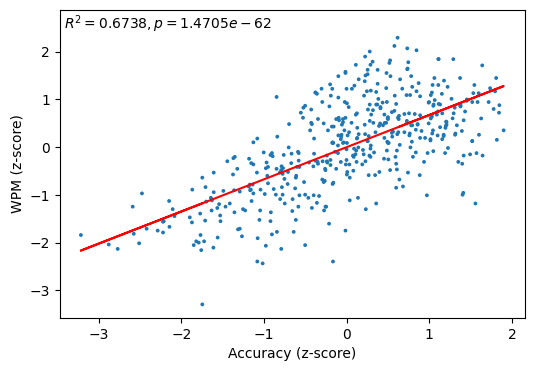

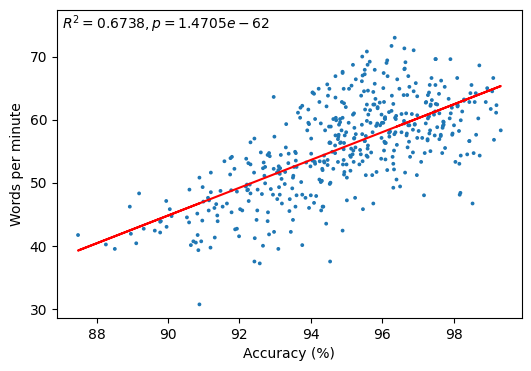

In [9]:
# Correlation between z_wpm and z_acc of the largest trial_type_id
fig = plt.figure(figsize=(6, 4))
ax = plot.df_scatter(df, "z_acc", "z_wpm", trial_type_id=1, plot_regression=True, s=3)
plt.show()

# Correlation between wpm and acc of the largest trial_type_id
fig = plt.figure(figsize=(6, 4))
ax = plot.df_scatter(df, "acc", "wpm", trial_type_id=1, plot_regression=True, s=3)
plt.show()

## Visualize z-scored data for all trials


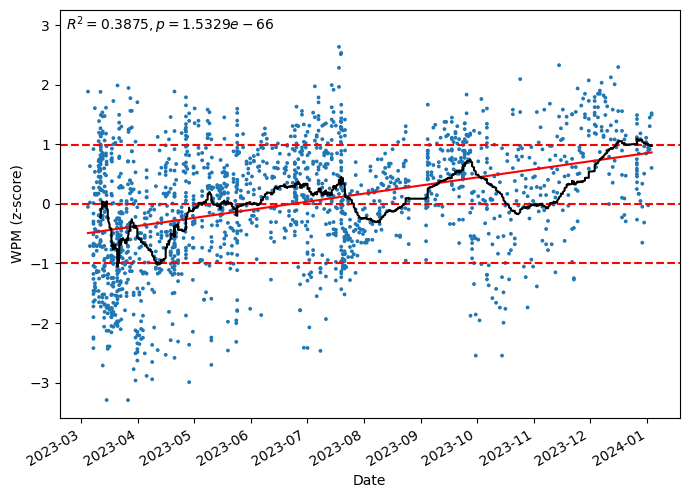

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = plot.df_scatter(df, "datetime", "z_wpm", plot_regression=True, s=3)  # datetime
# Add dashed lines for the mean and mean +/- 1 std
ax.axhline(df["z_wpm"].mean(), color="red", linestyle="--")
ax.axhline(df["z_wpm"].mean() + df["z_wpm"].std(), color="red", linestyle="--")
ax.axhline(df["z_wpm"].mean() - df["z_wpm"].std(), color="red", linestyle="--")
# Add a moving mean across 10 trials
ax.plot(df["datetime"], df["z_wpm"].rolling(100).mean(), color="k")
plt.show()

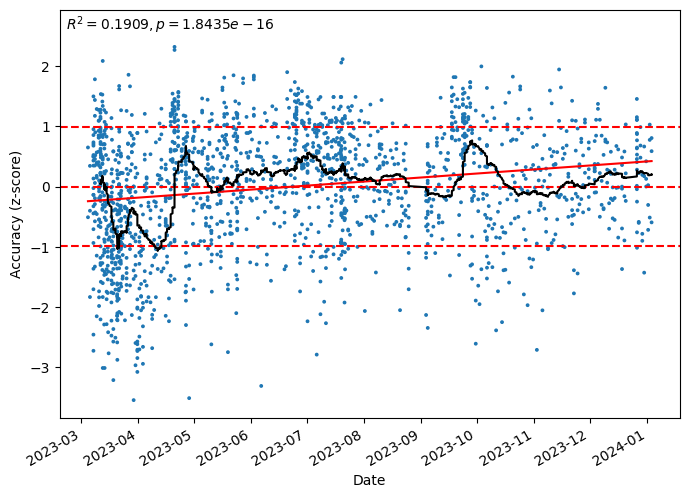

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plot.df_scatter(df, "datetime", "z_acc", plot_regression=True, s=3)  # datetime
# Add dashed lines for the mean and mean +/- 1 std
ax.axhline(df["z_acc"].mean(), color="red", linestyle="--")
ax.axhline(df["z_acc"].mean() + df["z_acc"].std(), color="red", linestyle="--")
ax.axhline(df["z_acc"].mean() - df["z_acc"].std(), color="red", linestyle="--")
# Add a moving mean across 10 trials
ax.plot(df["datetime"], df["z_acc"].rolling(100).mean(), color="k")
plt.show()

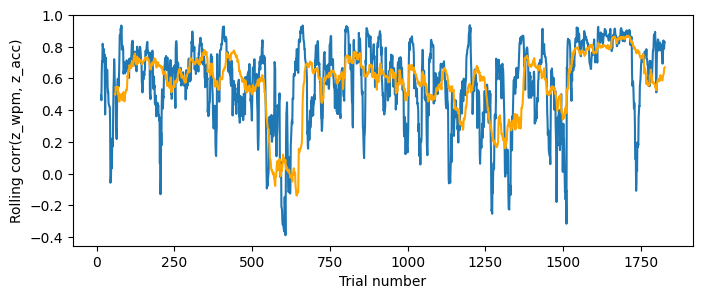

In [12]:
# Plot a rolling correlation between z_wpm and z_acc
ax = df["z_wpm"].rolling(15).corr(df["z_acc"]).plot(figsize=(8, 3))
# Add rolling correlation with a 10 trial window
ax.plot(df["z_wpm"].rolling(60).corr(df["z_acc"]), color="orange")
ax.set_xlabel("Trial number")
ax.set_ylabel("Rolling corr(z_wpm, z_acc)")
plt.show()

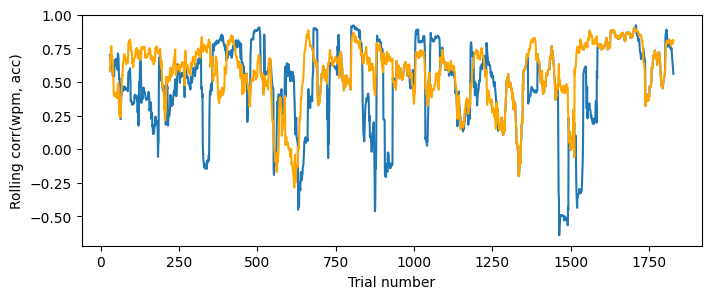

In [13]:
# Plot a rolling correlation between wpm and acc
ax = df["wpm"].rolling(30).corr(df["acc"]).plot(figsize=(8, 3))
# Plot a rolling correlation between z_wpm and z_acc
ax.plot(df["z_wpm"].rolling(30).corr(df["z_acc"]), color="orange")
ax.set_xlabel("Trial number")
ax.set_ylabel("Rolling corr(wpm, acc)")
plt.show()